# 2021/02/01 Lecture Summary 
## notMNIST로 보는 `pytorch` DataLoader 실습

[notMNIST dataset](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html)으로 DataLoader 클래스 만들기 & classification

* 참고: [pytorch dataset/dataloader/transforms tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

In [7]:
import torch
from PIL import Image, UnidentifiedImageError
import numpy as np
import os
import os.path
import glob
import random
from datetime import datetime
from torchvision import datasets, transforms
from typing import Callable, Optional, Tuple, Any
from torchvision.datasets.utils import download_and_extract_archive

classes = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9}

def get_data_and_label(img_pathes):
    img_arr = []
    label_arr = []
    for img_path in img_pathes:
        try:
            img = Image.open(img_path)
            img_arr.append(np.array(img))
            label_arr.append(classes[img_path.split('/')[-2]])
        except UnidentifiedImageError as e:
            continue
    return (torch.from_numpy(np.array(img_arr)), torch.from_numpy(np.array(label_arr)))

# Define NotMNIST Class - MNIST 참고
# https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py
class NotMNIST(datasets.vision.VisionDataset): # Image Classicifation DataLoader 
    # Resource file link
    train_src = 'http://yaroslavvb.com/upload/notMNIST/notMNIST_large.tar.gz'
    test_src = 'http://yaroslavvb.com/upload/notMNIST/notMNIST_small.tar.gz'

    training_file = 'training.pt'
    test_file = 'test.pt'
    
    # Properties
    @property
    def labels(self):
        return self.targets

    @property
    def train_data(self):
        return self.data

    @property
    def test_data(self):
        return self.data

    @property
    def raw_folder(self) -> str:
        return os.path.join(self.root, self.__class__.__name__, 'raw')
    
    @property
    def processed_folder(self) -> str:
        return os.path.join(self.root, self.__class__.__name__, 'processed')

    # Inner functions
    def download(self):
        if self._check_exists(): # 생성된 pt 파일의 존재여부 확인
            return
        os.makedirs(self.raw_folder, exist_ok=True)
        os.makedirs(self.processed_folder, exist_ok=True)

        # train file, test file을 다운로드
        train_filename = self.train_src.rpartition('/')[2]
        if not os.path.exists(os.path.join(self.raw_folder, train_filename)):
            download_and_extract_archive(self.train_src, download_root=self.raw_folder, filename=train_filename)
        test_filename = self.test_src.rpartition('/')[2]
        if not os.path.exists(os.path.join(self.raw_folder, test_filename)):
            download_and_extract_archive(self.test_src, download_root=self.raw_folder, filename=test_filename)
        
        # load files from raw_folder
        train_pathes = glob.glob(os.path.join(self.raw_folder, train_filename.split('.')[0], '*/*.png'))
        test_pathes = glob.glob(os.path.join(self.raw_folder, test_filename.split('.')[0], '*/*.png'))
        random.shuffle(train_pathes) # train data shuffle : 같은 label을 가진 데이터가 연속적으로 학습되는 상황 방지
        training_set = get_data_and_label(train_pathes)
        test_set = get_data_and_label(test_pathes)
        with open(os.path.join(self.processed_folder, self.training_file), 'wb') as f:
            torch.save(training_set, f)
        with open(os.path.join(self.processed_folder, self.test_file), 'wb') as f:
            torch.save(test_set, f)
        print('Done.')

    def _check_exists(self):
        return (os.path.exists(os.path.join(self.processed_folder,
                                            self.training_file)) and
                os.path.exists(os.path.join(self.processed_folder,
                                            self.test_file)))
    
    def __init__(
        self,
        root: str='',
        train: bool=True,
        transform: Optional[Callable]=None,
        target_transform: Optional[Callable]=None,
        download: bool=False,
        ) -> None:
        # transform: image -> transformed version으로 리턴하는 함수를 argument로 가짐
        # target_transform: target을 transform하는 함수를 argument로 가짐
        super(NotMNIST, self).__init__(root, transform=transform,
                                    target_transform=target_transform)
        random.seed(datetime.now()) # random seed를 시간으로 받음 -> seed 변경
        self.train = train

        # dataset이 존재하지 않는 경우: download
        if download:
            self.download() #TODO: implement this

        # training/test file의 존재여부 확인
        if not self._check_exists():
            raise RuntimeError('Dataset not found. You can use download=True to download it')
        
        # train/test 반환 체크
        if self.train:
            data_file = self.training_file
        else:
            data_file = self.test_file
        
        self.data, self.targets = torch.load(os.path.join(self.processed_folder, data_file))

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        img, target = self.data[index], int(self.targets[index])
        
        img = Image.fromarray(img.numpy(), mode='L')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)
        
        return img, target

    def __len__(self) -> int:
        return len(self.data)

In [8]:
root_path = './drive/MyDrive/2021_boostcamp/'

notmnist_train = NotMNIST(root=root_path,train=True,transform=transforms.ToTensor(), download=True) # load train dataset
notmnist_test = NotMNIST(root=root_path,train=False,transform=transforms.ToTensor(), download=True) # load test dataset
print ("mnist_train:\n",notmnist_train,"\n")
print ("mnist_test:\n",notmnist_test,"\n")
print ("Done.")

mnist_train:
 Dataset NotMNIST
    Number of datapoints: 529114
    Root location: ./drive/MyDrive/2021_boostcamp/
    StandardTransform
Transform: ToTensor() 

mnist_test:
 Dataset NotMNIST
    Number of datapoints: 18724
    Root location: ./drive/MyDrive/2021_boostcamp/
    StandardTransform
Transform: ToTensor() 

Done.


In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[1.7.0+cu101].
device:[cuda:0].


In [ ]:
BATCH_SIZE = 256
train_iter = torch.utils.data.DataLoader(notmnist_train,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
test_iter = torch.utils.data.DataLoader(notmnist_test,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
print ("Done.")

Done.


In [ ]:
class MultiLayerPerceptronClass(nn.Module):
    """
        Multilayer Perceptron (MLP) Class
    """
    def __init__(self,name='mlp',xdim=784,hdim=256,ydim=10):
        super(MultiLayerPerceptronClass,self).__init__()
        self.name = name
        self.xdim = xdim
        self.hdim = hdim
        self.ydim = ydim
        self.lin_1 = nn.Linear(
            self.xdim, # 입력 data의 dimension (28*28)
            self.hdim, # hidden layer의 dimension (16*16)
            bias=True
        )
        self.lin_2 = nn.Linear(
            self.hdim, # hidden layer의 dimension (16*16)
            self.ydim, # 출력, 즉 classification label의 개수 (10)
            bias=True
        )
        self.init_param() # initialize parameters
        
    def init_param(self):
        nn.init.kaiming_normal_(self.lin_1.weight)
        nn.init.zeros_(self.lin_1.bias)
        nn.init.kaiming_normal_(self.lin_2.weight)
        nn.init.zeros_(self.lin_2.bias)

    def forward(self,x):
        net = x # 데이터 입력
        net = self.lin_1(net) # 첫 번째 linear layer 통과
        net = F.relu(net) # relu activation 함수
        net = self.lin_2(net) # 두 번째 linear layer 통과
        return net # result

M = MultiLayerPerceptronClass(name='mlp',xdim=784,hdim=256,ydim=10).to(device) # MLP 모델 생성 & device에 올리기
loss = nn.CrossEntropyLoss() # MLP 모델에 사용할 Cross Entropy loss function
optm = optim.Adam(M.parameters(),lr=1e-3) # MLP 모델에 사용할 Optimizer
print ("Done.")

Done.


In [ ]:
def func_eval(model,data_iter,device):
    with torch.no_grad():
        model.eval() # evaluate (affects DropOut and BN)
        n_total,n_correct = 0,0
        for batch_in,batch_out in data_iter:
            y_trgt = batch_out.to(device)
            model_pred = model(
                batch_in.view(-1, 28*28).to(device) # (n, 28*28)로 reshape 후 model에 input data로 넣기
            )
            _,y_pred = torch.max(model_pred.data, 1) # torch.max(input, dimension): dimension은 reduce할 차원을 의미
            n_correct += (
                y_trgt == y_pred # target과 prediction의 일치 여부
            ).sum().item()
            n_total += batch_in.size(0) # shape tuple의 0번째 dimension 반환
        val_accr = (n_correct/n_total)
        model.train() # back to train mode 
    return val_accr
print ("Done")

Done


In [ ]:
M.init_param() # initialize parameters
train_accr = func_eval(M,train_iter,device)
test_accr = func_eval(M,test_iter,device)
print ("train_accr:[%.3f] test_accr:[%.3f]."%(train_accr,test_accr))

train_accr:[0.072] test_accr:[0.067].


In [ ]:
print ("Start training.")
M.init_param() # initialize parameters
M.train()
EPOCHS,print_every = 10,1
for epoch in range(EPOCHS):
    loss_val_sum = 0
    for batch_in,batch_out in train_iter:
        # Forward path
        y_pred = M.forward(batch_in.view(-1, 28*28).to(device))
        loss_out = loss(y_pred,batch_out.to(device))
        # Update
        optm.zero_grad() # reset gradient 
        loss_out.backward() # backpropagate
        optm.step() # optimizer update
        loss_val_sum += loss_out
    loss_val_avg = loss_val_sum/len(train_iter)
    # Print
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        train_accr = func_eval(M,train_iter,device)
        test_accr = func_eval(M,test_iter,device)
        print ("epoch:[%d] loss:[%.3f] train_accr:[%.3f] test_accr:[%.3f]."%
               (epoch,loss_val_avg,train_accr,test_accr))
print ("Done")        

Start training.
epoch:[0] loss:[0.458] train_accr:[0.893] test_accr:[0.947].
epoch:[1] loss:[0.355] train_accr:[0.903] test_accr:[0.951].
epoch:[2] loss:[0.323] train_accr:[0.912] test_accr:[0.956].
epoch:[3] loss:[0.303] train_accr:[0.917] test_accr:[0.958].
epoch:[4] loss:[0.288] train_accr:[0.920] test_accr:[0.959].
epoch:[5] loss:[0.276] train_accr:[0.923] test_accr:[0.959].
epoch:[6] loss:[0.267] train_accr:[0.927] test_accr:[0.960].
epoch:[7] loss:[0.257] train_accr:[0.927] test_accr:[0.960].
epoch:[8] loss:[0.250] train_accr:[0.931] test_accr:[0.961].
epoch:[9] loss:[0.243] train_accr:[0.931] test_accr:[0.961].
Done


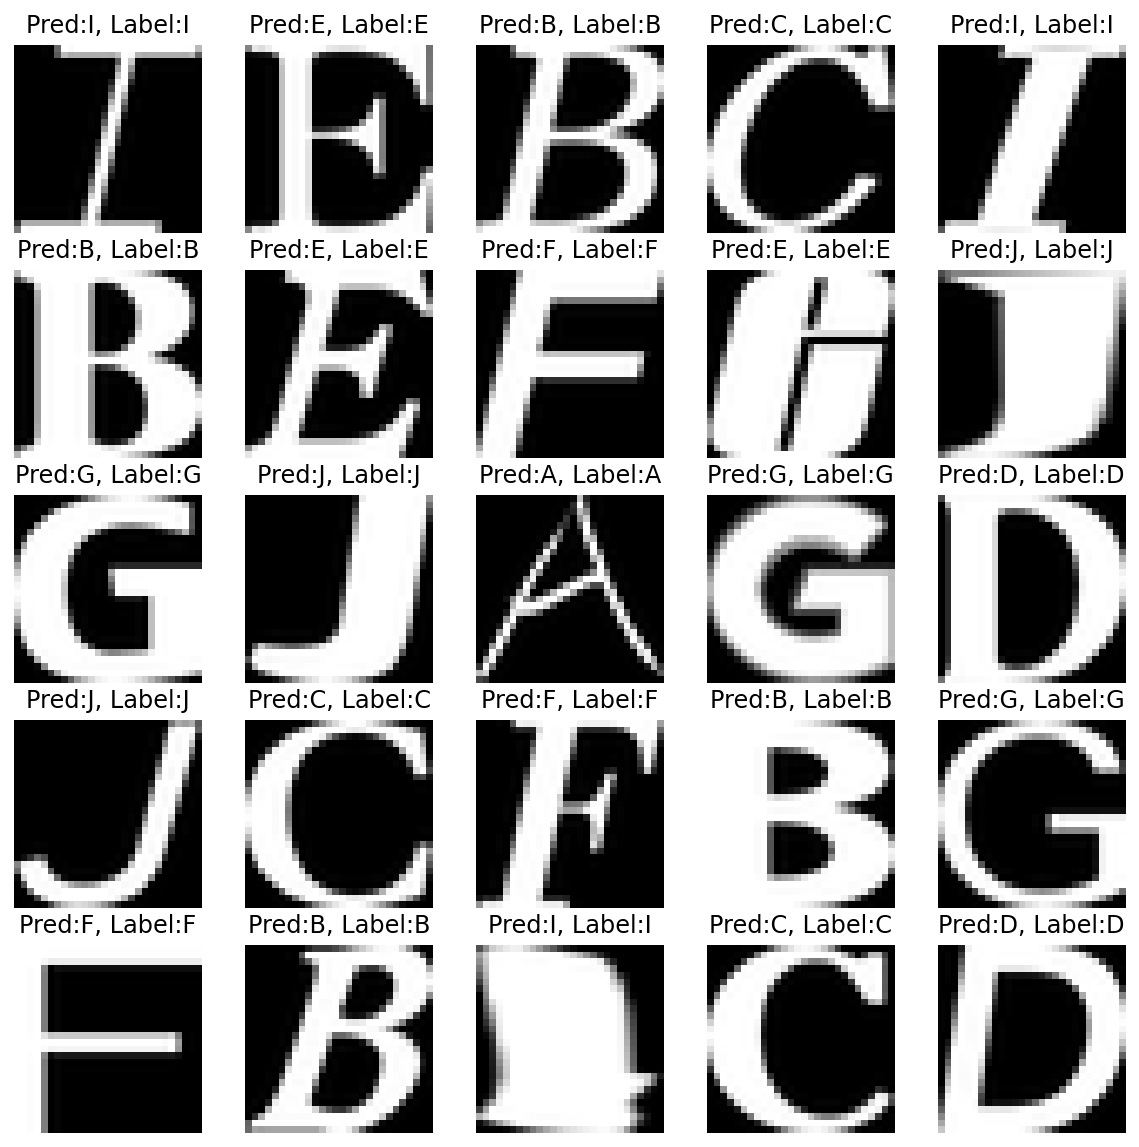

Done


In [ ]:
import matplotlib.pyplot as plt

n_sample = 25
sample_indices = np.random.choice(len(notmnist_test.targets), n_sample, replace=False)
test_x = notmnist_test.data[sample_indices]
test_y = notmnist_test.targets[sample_indices]
tmp_list = list(classes.keys())
with torch.no_grad():
    y_pred = M.forward(test_x.view(-1, 28*28).type(torch.float).to(device)/255.) # 학습된 model로 test dataset에 대한 결과 반환
y_pred = y_pred.argmax(axis=1)
plt.figure(figsize=(10,10))
for idx in range(n_sample):
    plt.subplot(5, 5, idx+1)
    plt.imshow(test_x[idx], cmap='gray')
    plt.axis('off')
    plt.title("Pred:%s, Label:%s"%(tmp_list[y_pred[idx].item()], tmp_list[test_y[idx].item()]))
plt.show()    
print ("Done")